In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" diµrectory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity

In [5]:
def first_infos(df, name):

    n_cols = len(df.columns)
    n_rows = len(df)
    n_duplicates = df.duplicated().sum()
    n_na = df.isna().sum().sum()

    print(name,'\n')
    print('cols number :',n_cols)
    print('rows number :',n_rows)
    print('duplicated value :',n_duplicates)
    print('nan number :',n_na)
    print(df.info())



In [6]:
dataset_train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv',sep=',')
dataset_client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv',sep=',')
dataset_elec_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv',sep=',')
dataset_forcast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv',sep=',')
dataset_gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv',sep=',')
dataset_historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv',sep=',')
dataset_weather_station = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv',sep=',')
dataset_sample_submission = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv',sep=',')
dataset_test = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv',sep=',')
dataset_test_client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv',sep=',')
dataset_test_elec_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity_prices.csv',sep=',')
dataset_test_forecast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/forecast_weather.csv',sep=',')
dataset_test_gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv',sep=',')
dataset_test_historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/historical_weather.csv',sep=',')
dataset_revealed_targets = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/revealed_targets.csv',sep=',')

# 1.2 Merge dataset train

In [7]:
# merge df_train-gas_price and dataset_gas_prime
# jointure du dataframe dataset_train et dataset_gas_prime

df_train_gas = pd.merge(dataset_train, dataset_gas_prices, on='data_block_id', how='left')
df_train_gas

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-30,29.0,34.0,2023-05-29
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-30,29.0,34.0,2023-05-29
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-30,29.0,34.0,2023-05-29
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-30,29.0,34.0,2023-05-29


In [8]:
# merge dataset_client and dataset_elec_price
# jointure du dataframe dataset_train et dataset_gas_prime

df_client_elec = pd.merge(dataset_client, dataset_elec_prices, left_on='data_block_id', right_on='data_block_id')
df_client_elec

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,forecast_date,euros_per_mwh,origin_date
0,1,0,108,952.89,0,2021-09-01,2,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00
1,1,0,108,952.89,0,2021-09-01,2,2021-09-02 01:00:00,94.77,2021-09-01 01:00:00
2,1,0,108,952.89,0,2021-09-01,2,2021-09-02 02:00:00,93.88,2021-09-01 02:00:00
3,1,0,108,952.89,0,2021-09-01,2,2021-09-02 03:00:00,92.25,2021-09-01 03:00:00
4,1,0,108,952.89,0,2021-09-01,2,2021-09-02 04:00:00,91.83,2021-09-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...
1005918,3,15,55,2188.20,1,2023-05-29,637,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00
1005919,3,15,55,2188.20,1,2023-05-29,637,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00
1005920,3,15,55,2188.20,1,2023-05-29,637,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00
1005921,3,15,55,2188.20,1,2023-05-29,637,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00


In [9]:
# merge df_train_gas and dataset_client

df_train_gas_client = pd.merge(df_train_gas, dataset_client, on=['data_block_id', 'county', 'product_type', 'is_business'], how='left')
df_train_gas_client

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,eic_count,installed_capacity,date
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-30,29.0,34.0,2023-05-29,15.0,620.0,2023-05-29
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-30,29.0,34.0,2023-05-29,20.0,624.5,2023-05-29
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-30,29.0,34.0,2023-05-29,20.0,624.5,2023-05-29
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-30,29.0,34.0,2023-05-29,55.0,2188.2,2023-05-29


In [10]:
# convert the variable datetime in datetime format 

df_train_gas_client.datetime = pd.to_datetime(df_train_gas_client.datetime)
dataset_forcast_weather.origin_datetime = pd.to_datetime(dataset_forcast_weather.origin_datetime)

In [11]:
tab_df = []

# Regrouper les données d'entraînement par année et mois
grouped_train = df_train_gas_client.groupby([df_train_gas_client.datetime.dt.year, df_train_gas_client.datetime.dt.month])

# Regrouper les données de prévision par année et mois
grouped_forecast = dataset_forcast_weather.groupby([dataset_forcast_weather.origin_datetime.dt.year, dataset_forcast_weather.origin_datetime.dt.month])

# Itérer sur les groupes de données
for (year, month), df_train_group in grouped_train:
    
    if (year, month) in grouped_forecast.groups:
        df_forecast_group = grouped_forecast.get_group((year, month))
        # Effectuer la jointure interne entre les données de prévision et d'entraînement
        #df_merged = pd.merge(df_forecast_group, df_train_group, left_on='origin_datetime', right_on='datetime', how='inner')
        df_forecast_group = df_forecast_group.loc[df_forecast_group.origin_datetime.isin(df_train_group.datetime.unique())]
        df = pd.concat([df_forecast_group.reset_index(),df_train_group.reset_index()],axis=1)
        tab_df.append(df.dropna())
        #tab_df.append(df_train_group)
        

    else:
        print(f"Aucune donnée de prévision pour {year}-{month}.")
    
    


In [12]:
df_train_forecast = pd.concat(tab_df, axis=0)
df_train_forecast = df_train_forecast.reset_index().drop(columns=["index","level_0"])
df_train_forecast.set_index('datetime',inplace=True)
df_train_forecast.head(1)


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,...,data_block_id,row_id,prediction_unit_id,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,eic_count,installed_capacity,date
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-03,58.2,23.7,2021-09-02 02:00:00,5,13.476221,6.160547,0.0,0.238205,0.304855,0.36731,...,2.0,5856.0,0.0,2021-09-02,45.62,46.29,2021-09-01,108.0,952.89,2021-09-01


# Prediction de la variale target avec le modèle Xgboost

In [13]:
def new_features(df_features):
    
        df_features["hour"] = df_features["datetime"].dt.hour
        df_features["day"] = df_features["datetime"].dt.day
        df_features["weekday"] = df_features["datetime"].dt.weekday
        df_features["month"] = df_features["datetime"].dt.month
        df_features["year"] = df_features["datetime"].dt.year
        df_features["dayofyear"] = df_features["datetime"].dt.dayofyear
        
        # Ajouter les colonnes sinusoïdales pour capturer la cyclicité
        df_features["sin_dayofyear"] = np.sin(np.pi * df_features["dayofyear"] / 183)
        df_features["cos_dayofyear"] = np.cos(np.pi * df_features["dayofyear"] / 183)
        df_features["sin_hour"] = np.sin(np.pi * df_features["hour"] / 12)
        df_features["cos_hour"] = np.cos(np.pi * df_features["hour"] / 12)
        
        return df_features

In [14]:
df_train_forecast['datetime'] = df_train_forecast.index
df_train_forecast2 = new_features(df_train_forecast)
cols = df_train_forecast2.drop(columns=['latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns
cols

Index(['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'is_business', 'product_type', 'target', 'is_consumption',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'sin_dayofyear', 'cos_dayofyear', 'sin_hour', 'cos_hour'],
      dtype='object')

In [15]:
cols = df_train_forecast2.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns
cols

Index(['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'is_business', 'product_type', 'target', 'is_consumption',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'sin_dayofyear', 'cos_dayofyear', 'sin_hour', 'cos_hour'],
      dtype='object')

In [16]:

# Exemple de création de variables retardées
def create_lagged_features(df, target,lags):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df


temps d execution :  9.82761836051941


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


RMSE: 349.47391113565436


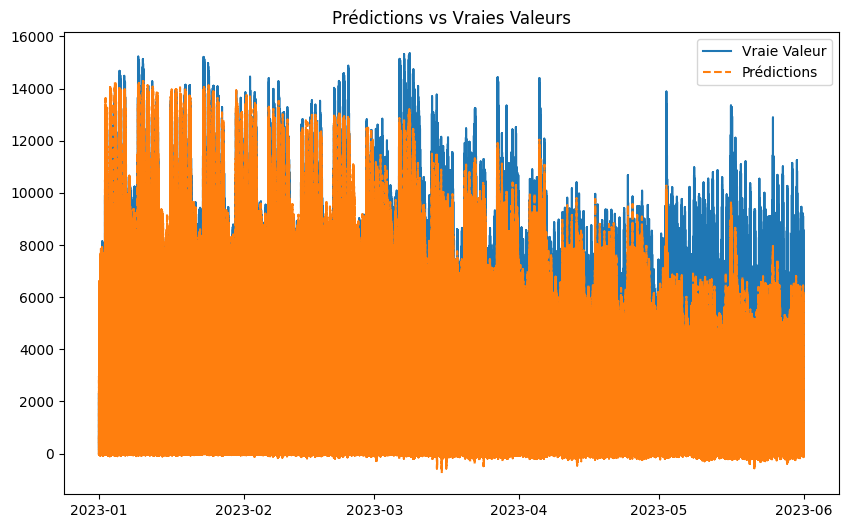

In [17]:
import time

cols = df_train_forecast2.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
X_train = df_train_forecast2.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022), cols]
X_test = df_train_forecast2.loc[(df_train_forecast2.index.year==2023), cols]
# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de test
y_train = df_train_forecast2.target.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022)]
y_test = df_train_forecast2.target.loc[(df_train_forecast2.target.index.year == 2023)]

lags = [1, 2, 3, 7, 14, 40] 

X_train_lag = create_lagged_features(X_train,'target',lags=lags)
X_train_lag.dropna(inplace=True)
X_test_lag = create_lagged_features(X_test,'target',lags=lags)
X_test_lag.dropna(inplace=True)

X_train_lag.drop(columns='target',inplace=True)
X_test_lag.drop(columns='target',inplace=True)

t1 = time.time()
# Créer et entraîner le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror', subsample = 0.6, n_estimators=300, learning_rate=0.1, max_depth=6,tree_method='hist', device='cuda')
model.fit(X_train_lag, y_train[40:])
t2 = time.time()
print('temps d execution : ', (t2-t1))# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}

# Faire des prédictions
y_pred = model.predict(X_test_lag)

# Calculer l'erreur quadratique moyenne
rmse = np.sqrt(mean_squared_error(y_test[40:], y_pred))
print(f'RMSE: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index[40:], y_test[40:], label='Vraie Valeur')
plt.plot(y_test.index[40:], y_pred, label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

# Interpréation du modèle 

In [18]:
# Importance des caractéristiques par "weight"
importance_weight = model.get_booster().get_score(importance_type='weight')

# Importance des caractéristiques par "gain"
importance_gain = model.get_booster().get_score(importance_type='gain')

# Importance des caractéristiques par "cover"
importance_cover = model.get_booster().get_score(importance_type='cover')


In [19]:
df_importances_weight = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Gain': list(importance_gain.values())
})

# Trier le DataFrame par poids (du plus élevé au plus bas)
df_importances_gain_sorted = df_importances_weight.sort_values(by='Gain', ascending=True)


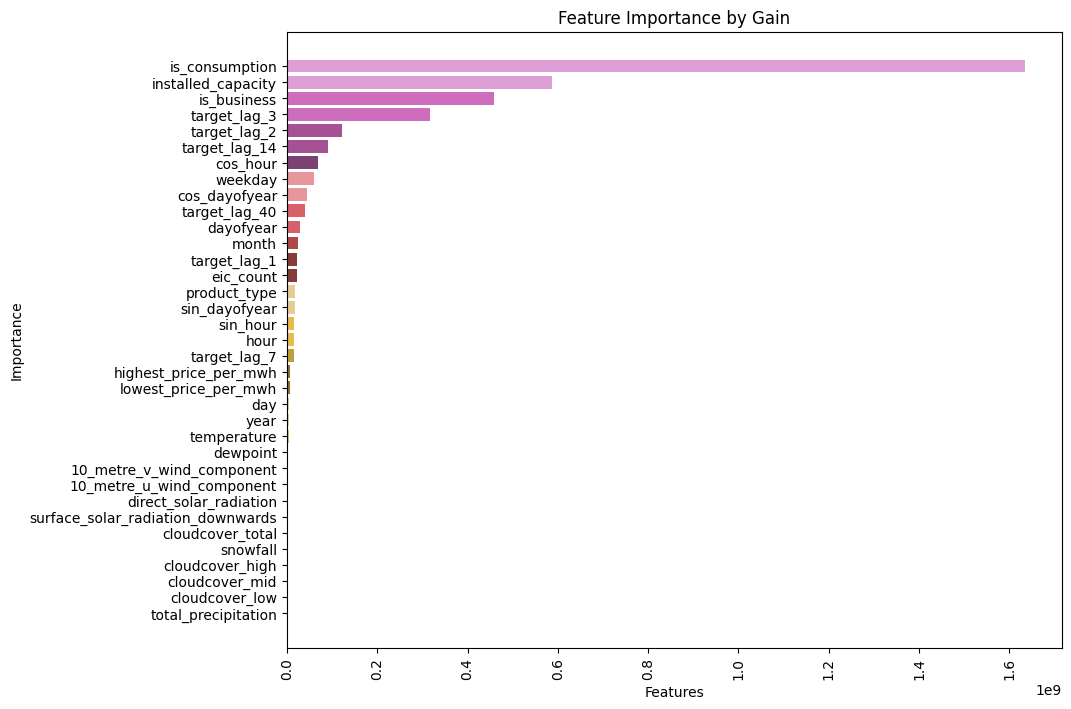

In [20]:
# Visualiser l'importance par 'gain'
colors = plt.cm.tab20b(np.linspace(0, 1, len(df_importances_gain_sorted)))

plt.figure(figsize=(10, 8))
plt.barh(df_importances_gain_sorted.Feature, df_importances_gain_sorted.Gain, color= colors)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=90) 
plt.title('Feature Importance by Gain')
plt.show()


# Les variable contribuants au performance du modèle Xgboost
 - is_consumption 
 - installed_capacity 
 - is_business
 - target_lag3
 - target_lag2
 - target_lag14
 - cos_hour
 - weekday
 - cos_dayofyear
 - target_lag1
 - month
 - eic_count

In [21]:
import shap

# Créer un explainer SHAP avec TreeExplainer
explainer = shap.TreeExplainer(model)

In [22]:
# Calculer les valeurs SHAP pour les données test
shap_values = explainer.shap_values(X_test_lag, check_additivity=False)

# Interprétation globale 

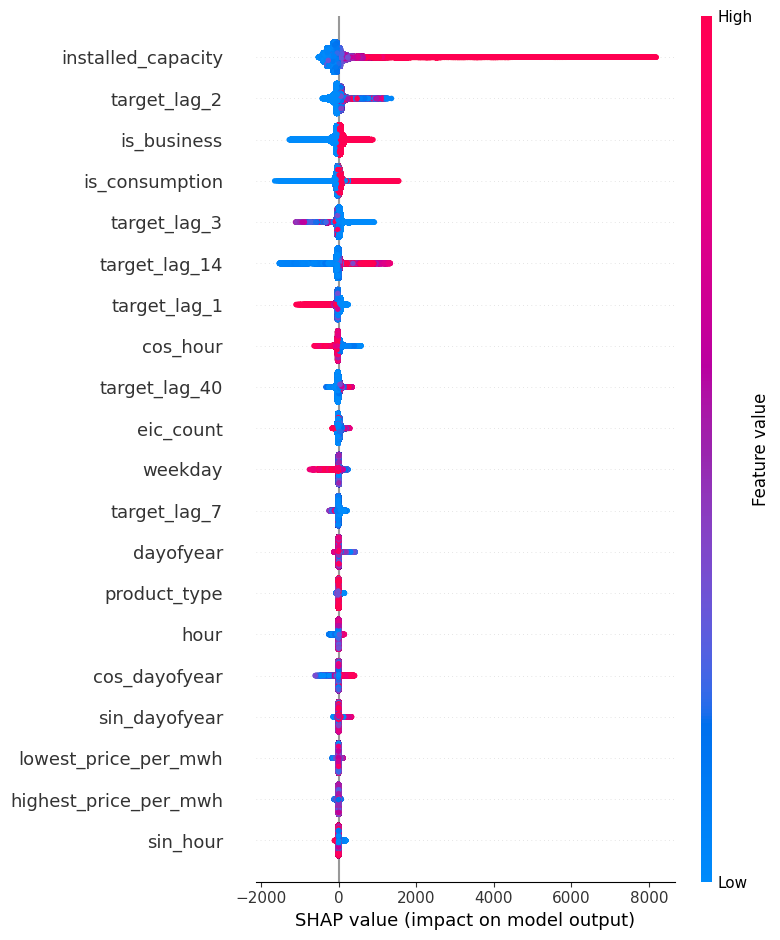

In [23]:
# Résumer des variables qui influencent les prédictions de la consommation et de la production électrique 
shap.summary_plot(shap_values, X_test_lag, feature_names=model.feature_names_in_)

# Interprétation locale

In [24]:
print('Nombre de valeur pour le premier janvier 2023 :',len(y_test.loc[(y_test.index.month == 1)&(y_test.index.day ==1)].index))

Nombre de valeur pour le premier janvier 2023 : 3216


In [25]:
shap.initjs()
# Analyse de la contribution des variables pour la consommation et la production d'énergie électrique du 1er janvier 2023
shap.force_plot(explainer.expected_value, shap_values[40:1000,:], X_train_lag.iloc[40:1000,:],feature_names=model.feature_names_in_)

In [26]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [27]:
counter = 0
for (test, revealed_targets, client, historical_weather,forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    if counter == 0:
        display(test.head(3))
        display(revealed_targets.head(3))
        display(client.head(3))
        display(historical_weather.head(3))
        display(forecast_weather.head(3))
        display(electricity_prices.head(3))
        display(gas_prices.head(3))
        display(sample_prediction.head(3))
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,county,is_business,product_type,is_consumption,prediction_datetime,row_id,prediction_unit_id,currently_scored
0,0,False,1,False,1685232000000000000,2005872,0,False
1,0,False,1,True,1685232000000000000,2005873,0,False
2,0,False,2,False,1685232000000000000,2005874,1,False


,county,is_business,product_type,target,is_consumption,datetime,row_id,prediction_unit_id
0,0,False,1,2.675,False,1685059200000000000,1999536,0
1,0,False,1,471.887,True,1685059200000000000,1999537,0
2,0,False,2,0.000,False,1685059200000000000,1999538,1


,product_type,county,eic_count,installed_capacity,is_business,date
0,1,0,507,4960.214844,False,1685059200000000000
1,2,0,11,34.000000,False,1685059200000000000
2,3,0,1516,15977.559570,False,1685059200000000000


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude
0,1685098800000000000,13.5,9.0,0.0,0.0,1018.500000,30,31.0,3.0,0.0,6.305555,272.0,592.0,420.0,172.0,57.599998,21.700001
1,1685098800000000000,13.4,8.9,0.2,0.0,1013.200012,47,31.0,32.0,0.0,6.111111,268.0,612.0,446.0,166.0,57.599998,22.200001
2,1685098800000000000,16.4,7.8,0.2,0.0,1017.700012,60,21.0,69.0,0.0,6.138889,263.0,655.0,512.0,143.0,57.599998,22.700001


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.599998,21.700001,1685152800000000000,1,9.859156,5.508813,0.0,0.0,0.026901,0.026901,3.616620,-1.281012,1685156400000000000,0.0,0.0,0.0,0.0
1,57.599998,22.200001,1685152800000000000,1,5.916284,4.613428,0.0,0.0,0.000000,0.000000,2.164227,-0.245367,1685156400000000000,0.0,0.0,0.0,0.0
2,57.599998,22.700001,1685152800000000000,1,9.111963,6.878442,0.0,0.0,0.000000,0.000000,3.809247,-1.583502,1685156400000000000,0.0,0.0,0.0,0.0


,forecast_date,euros_per_mwh,origin_date
0,1685145600000000000,87.54,1685059200000000000
1,1685149200000000000,82.69,1685062800000000000
2,1685152800000000000,82.70,1685066400000000000


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date
0,1685145600000000000,28.299999,34.099998,1685059200000000000


,row_id,target
0,2005872,0.0
1,2005873,0.0
2,2005874,0.0


In [28]:
df_pred = df_train_forecast2.loc[(df_train_forecast2.index.year==2023)].iloc[40:,:]

df_pred['target_pred'] = y_pred

mask = df_pred.row_id.isin(dataset_sample_submission.row_id)

df_pred = df_pred.loc[mask]

In [29]:
dataset_sample_submission.loc[:,'target'] = df_pred.target_pred.values.copy()
dataset_sample_submission2 = dataset_sample_submission[['row_id','target']]

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-14.918076 453.7538     1.530716 ... 114.890915  18.600998 917.0765  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


In [ ]:
dataset_sample_submission2.to_csv('/kaggle/working/submission.csv')